In [1]:
# read parallel dataset, generate all suffixes, and write to file

In [1]:
import codecs

import numpy as np

from nn_imt.stream import imt_f1, map_pair_to_imt_triples


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [2]:
source_file = '/media/1tb_drive/multilingual-multimodal/flickr30k/test/test.en.tok'
reference_file = '/media/1tb_drive/multilingual-multimodal/flickr30k/test/test.de.tok'

suffix_temporary_file = '/media/1tb_drive/multilingual-multimodal/flickr30k/test/imt_suffixes.de.tok.tmp'
translated_output_file = '/media/1tb_drive/multilingual-multimodal/flickr30k/train/processed/test.imt_PROTO-DELETE-ME.30.x.hyps.out'

# your desired path to the translated output file, or an already-translated file that you just want to evaluate
#'translated_output_file': '/media/1tb_drive/multilingual-multimodal/flickr30k/train/processed/dev.multimodal-summed.30.x.hyps.out'



In [3]:
# WORKING:
with codecs.open(source_file, encoding='utf8') as srcs:
    with codecs.open(reference_file, encoding='utf8') as refs:
        with codecs.open(suffix_temporary_file, 'w', encoding='utf8') as ref_tmp:
            # map (source, ref) to [(source, prefix, suffix)]
            source_lines = srcs.read().strip().split('\n')
            ref_lines = refs.read().strip().split('\n')
            assert len(source_lines) == len(ref_lines), 'Source and reference files must be the same length'
            for i, instance in enumerate(zip(source_lines, ref_lines)):
#                 logger.info("Generating reference suffixes for line: {}".format(i))

                # TODO: tokenization is not currently implemented -- assumes whitespace tokenization!!!
                # Right now, tokenization happens in self.map_idx_or_unk if predict_segment is passed a string
                source_seq = instance[0].split()
                target_seq = instance[1].split()

                # map to triples
                imt_triples = map_pair_to_imt_triples(source_seq, target_seq)

                # the first instance contains the empty prefix, the last instance contains the empty suffix
                # HACK: pop the first item until a fix for empty prefix is implemented
                imt_triples = imt_triples[1:]

#                 print(imt_triples)
                
                # write each line in the reference suffixes to a file
                srcs, prefixes, suffixes = zip(*imt_triples)
#                 print(suffixes)
                
                # map back to whitespace-tokenized string
                suffixes = [' '.join(s) for s in suffixes]
                
                ref_tmp.write('\n'.join(suffixes) + '\n')
            

                ################

#         logger.info("Saved translated output to: {}".format(ftrans.name))
#         logger.info("Total cost of the test: {}".format(total_cost))
#         ftrans.close()

#         return output_file

In [4]:

with codecs.open(translated_output_file, encoding='utf8') as hyps:
    with codecs.open(suffix_temporary_file, encoding='utf8') as refs:
        hyp_lines = hyps.read().strip().split('\n')
        ref_lines = refs.read().strip().split('\n')
        print(len(ref_lines))
        
#         last line of each hyp set is currently '</S> .', remove this -- corresponding ref line is empty
        hyp_lines = hyp_lines[:-1]
        print(len(hyp_lines))
        hyp_lines = ['' if h == '</S> .' else h for h in hyp_lines]
        assert len(hyp_lines) == len(ref_lines), 'Source and reference files must be the same length'
        
        # split into lists of tokens
        hyp_lines = [s.split() for s in hyp_lines]
        ref_lines = [s.split() for s in ref_lines]

# ref_lines[:30]    

6551
6551


In [5]:
def truncate_lines(l_of_l, cutoff):
    return [l[:cutoff] for l in l_of_l]

In [6]:
thresholds = range(1,10)
imt_f1_threshold_scores = []

for threshold in thresholds:
    threshold_hyps = truncate_lines(hyp_lines, threshold)
    imt_scores = [imt_f1(hyp, ref) for hyp, ref in zip(threshold_hyps, ref_lines)]
    # f1, precision, recall
    scores_at_t = [np.mean(s) for s in zip(*imt_scores)]
    print(scores_at_t)
    imt_f1_threshold_scores.append(scores_at_t)

[0.26384104957537668, 0.57441611967638528, 0.21701206532940204]
[0.31296896680141767, 0.49282552282094338, 0.26792026363039123]
[0.32802198957082745, 0.43754134228870906, 0.29196760361793045]
[0.33121043275661216, 0.40023151681677105, 0.3042693759580124]
[0.3301289858658632, 0.37519717091538191, 0.31044147027893465]
[0.3277343346118316, 0.35822266320663515, 0.3134671382456144]
[0.32535004152067509, 0.34683581568789934, 0.3150204061132586]
[0.32340657560800573, 0.33931242776457249, 0.31584944104021428]
[0.32203701145571201, 0.33455700450434078, 0.31630637045006516]


In [7]:
# now graph f1, precision, recall over threshold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pylab
pylab.rcParams['figure.figsize'] = (14.0, 12.0)

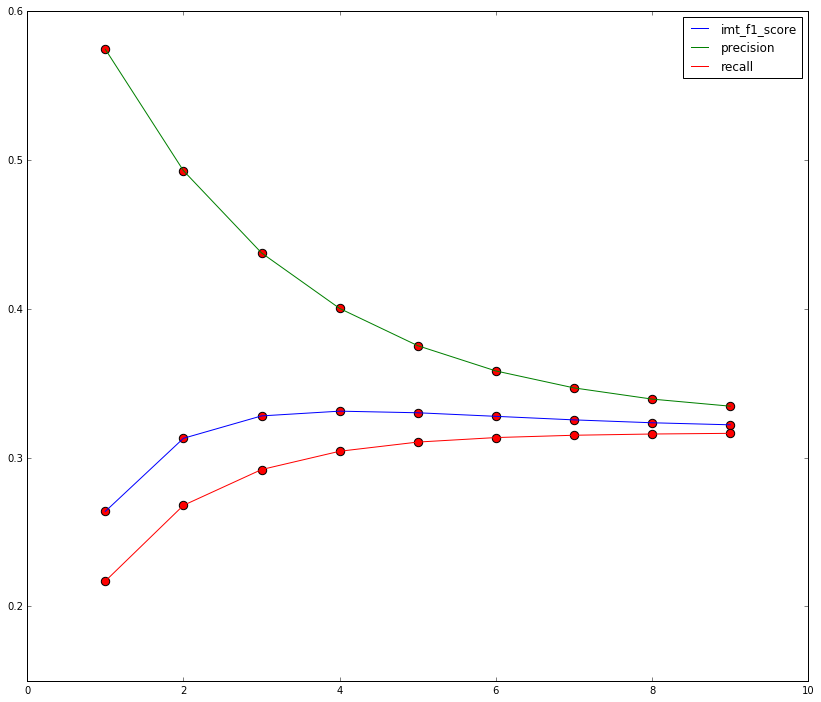

In [8]:
fig, ax = plt.subplots()

names = ['imt_f1_score', 'precision', 'recall']
metrics = zip(*imt_f1_threshold_scores)
# for i,key_points in enumerate(all_points):

for i in range(len(names)):
    name = names[i]
    x = thresholds
    y = metrics[i]
    ax.scatter(x, y, s=70, c='red')
    plt.plot(x, y, label=name)
    

plt.legend()

In [13]:
thresholds

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
# now compute f1_imt for each hyp, ref_suffix pair
imt_scores = [imt_f1(hyp, ref) for hyp, ref in zip(hyp_lines, ref_lines)]
np.mean(imt_scores)

0.32075105789557112

In [16]:
len(imt_scores)

6551